# Provided Functions

In [1]:
from typing import NamedTuple, Optional, Tuple, Generator, List

import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import circle_perimeter_aa


class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int


def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


def noisy_circle(
    img_size: int, min_radius: float, max_radius: float, noise_level: float
) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)


def show_circle(img: np.ndarray):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title('Circle')
    plt.show()


def generate_examples(
    noise_level: float = 0.5,
    img_size: int = 100,
    min_radius: Optional[int] = None,
    max_radius: Optional[int] = None,
    dataset_path: str = 'ds',
) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = f"{noise_level=}, {img_size=}, {min_radius=}, {max_radius=}, {dataset_path=}"
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level
        )
        yield img, params


def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        return 0
    if d <= abs(r1 - r2):
        # ORIGNAL CODE
        # return 1
        # MY CHANGE
        # When one circle is contained within the other, why return 1? Instead, return the ratio of the smaller circle : larger circle
        return (np.pi * min(r1, r2)**2) / (np.pi * max(r1, r2)**2)
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    h1 = r1_sq * np.arccos(d1 / r1)
    h2 = d1 * np.sqrt(r1_sq - d1**2)
    h3 = r2_sq * np.arccos(d2 / r2)
    h4 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = h1 + h2 + h3 + h4
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union


# Exploration

## Exploring Provided Functions/Data

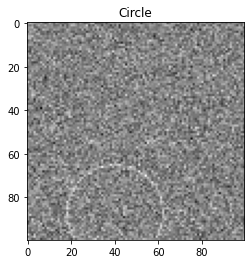

In [2]:
# Visualize a noisy circle
test_image, _params = noisy_circle(100, 5, 30, 0.5)
show_circle(test_image)


Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


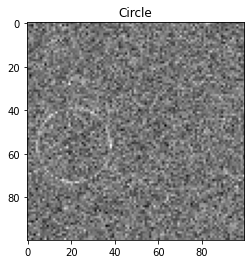

CircleParams(row=56, col=21, radius=17)


In [3]:
# Visualize a generated noisy circle
test_image, params = next(generate_examples())
show_circle(test_image)
print(params)


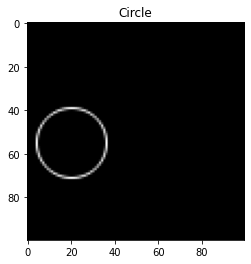

In [4]:
# Visualize a circle with parameters that are each one-off from the circle generated above
one_off_params = CircleParams(
    params.row - 1, params.col - 1, params.radius - 1)
one_off_circle = draw_circle(np.zeros(
    (100, 100)), one_off_params.row, one_off_params.col, one_off_params.radius)
show_circle(one_off_circle)


In [5]:
# iou between the circle and itself
print(iou(params, params))

# iou between the circle and the one-off parameter circle
print(iou(params, one_off_params))


1.0
0.9411732471680136


## Exploring data using convolutions

Smooth the noisy image using a Gaussian Kernel

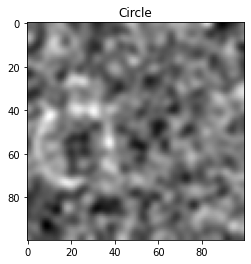

In [6]:
# Show a smoothed image with a strong gaussian filter
import scipy.ndimage
smooth_image = scipy.ndimage.gaussian_filter(test_image, sigma=2)
show_circle(smooth_image)


Visualize gradient filters on the smooth image

In [7]:
import scipy.signal


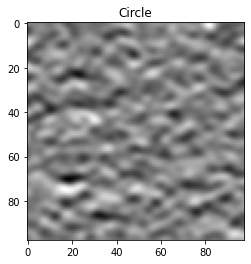

In [8]:
# Show the smoothed circled with a vertical gradient filter
vertical_gradient_filter = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
show_circle(scipy.signal.convolve(
    smooth_image, vertical_gradient_filter, mode='valid'))


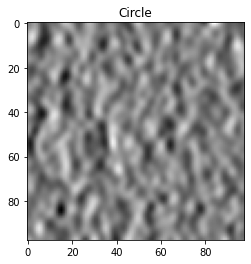

In [9]:
# Show the smoothed circle with a horizontal gradient filter
horizontal_gradient_filter = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
show_circle(scipy.signal.convolve(
    smooth_image, horizontal_gradient_filter, mode='valid'))


Try convolving a template image over a noisy example

In [10]:
# Create a template image to use as a large filter
template = draw_circle(np.zeros((100, 100)), 50, 50, params.radius)


In [11]:
# Pad the original image with values of 0.5
padded_image = np.ones((200, 200)) * 0.5
padded_image[50:150, 50:150] = test_image


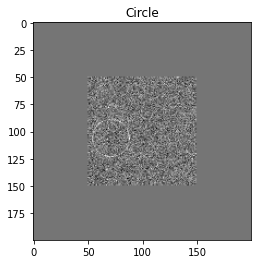

In [12]:
show_circle(padded_image)


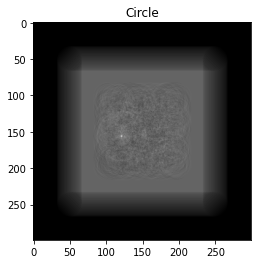

In [13]:
# Convolve the template over the padded image
convolution_result = scipy.signal.convolve(padded_image, template, mode='full')
show_circle(convolution_result)


Print the location maximum value in the convolution. This should be the (relative) location of the circle center.

In [14]:
# Maximal location of convolution
print(np.unravel_index(convolution_result.argmax(), convolution_result.shape))
# Original parameters
print(params)


(156, 121)
CircleParams(row=56, col=21, radius=17)


# Brute Force CV solution

Idea: For every possible radius, convolve a template image over a given noisy circle. Find the maximum value for each convolution. We can then find which maximum corresponds to the highest value (relative to the filter size).

This gives us the centroid of the circle and the size of its radius.


In [15]:
def cv_solution(img_size: int, min_radius: int, max_radius: int, test_image) -> Tuple[Tuple[int, int, int], np.ndarray, List[int], List[int]]:
    # Normalize image between -0.5 and 0.5
    test_image = (test_image - np.min(test_image)) / \
        (np.max(test_image) - np.min(test_image)) - 0.5

    # Pad image with zeros
    padded_image = np.zeros((img_size * 2, img_size * 2))
    padded_image[img_size // 2: 3 * img_size // 2,
                 img_size // 2: 3 * img_size // 2] = test_image

    best_convolution = None
    best_prediction = (0, 0, 0)
    max_value = 0
    template_radiuses = []
    max_val_to_template_ratios = []
    # Iterate over every possible radius value
    for template_radius in range(min_radius, max_radius):
        # Create template image
        template = draw_circle(
            np.zeros((img_size, img_size)), img_size//2, img_size//2, template_radius)

        # Convolve template over the padded noisy image
        convolution_result = scipy.signal.convolve(
            padded_image, template, mode='full')
        padded_location_prediction = np.unravel_index(
            convolution_result.argmax(), convolution_result.shape)

        # Compute a ratio between the maximum convolution result and the sum of the template values
        max_val_to_template_ratio = np.max(
            convolution_result)**2 / np.sum(template)

        # Save values for plotting and debugging
        max_val_to_template_ratios.append(max_val_to_template_ratio)
        template_radiuses.append(template_radius)

        # Store the maximum ratio, prediction, and convolution
        if max_val_to_template_ratio >= max_value:
            max_value = np.max(convolution_result)**2 / np.sum(template)
            best_prediction = CircleParams(
                padded_location_prediction[0]-img_size, padded_location_prediction[1]-img_size, template_radius)
            best_convolution = convolution_result

    return best_prediction, best_convolution, template_radiuses, max_val_to_template_ratios


Using parameters: noise_level=0.7, img_size=100, min_radius=5, max_radius=50, dataset_path='ds'


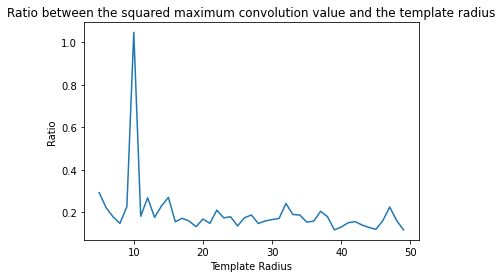

Predicted circle: CircleParams(row=69, col=25, radius=10)
Ground truth circle: CircleParams(row=69, col=25, radius=10)
IOU: 1.0


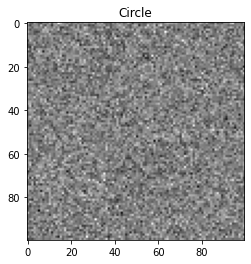

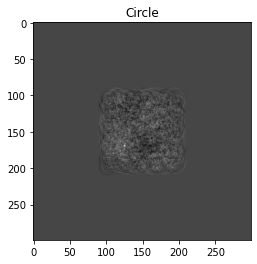

In [16]:
noise_level = 0.7
img_size = 100
min_radius = 5
max_radius = 50
test_image, ground_truth_params = next(generate_examples(
    noise_level=noise_level, img_size=img_size, min_radius=min_radius, max_radius=max_radius))

# Run the cv solution
best_prediction, best_convolution, template_radiuses, max_val_to_template_ratios = cv_solution(
    img_size, min_radius, max_radius, test_image)

# Plot all max convolution value ratios vs. radius size (maximal value should be at the correct radius size)
plt.plot(template_radiuses, max_val_to_template_ratios)
plt.xlabel("Template Radius")
plt.ylabel("Ratio")
plt.title(
    "Ratio between the squared maximum convolution value and the template radius")
plt.show()

# Print results
print(f"Predicted circle: {best_prediction}")
print(f"Ground truth circle: {ground_truth_params}")
print(f"IOU: {iou(best_prediction, ground_truth_params)}")

# Show input image and the convolutional result
show_circle(test_image)
show_circle(best_convolution)


## Analysis: Noise-level vs Accuracy

Using parameters: noise_level=0.0, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.1, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.2, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.30000000000000004, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.4, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.5, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.6000000000000001, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.7000000000000001, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.8, img_size=100, min_radius=5, max_radius=40, dataset_path='ds'
Using parameters: noise_level=0.9, img_size=100, min_radius=5, max_radius=40, dataset_path

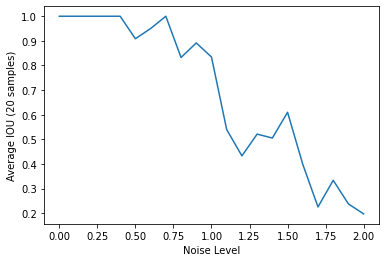

In [18]:
def plot_iou_vs_noiselevel(img_size: int, min_radius: int, max_radius: int):
    '''
      Plot average iou values against noise level. Demonstrates how accuracy decreases as noise increases.
    '''

    noise_levels = []
    avg_ious = []
    n = 20
    # Evaluate every .1 noise level between 0 and 2
    for noise_level in np.linspace(0, 2, 21):
        # Create image generator
        generator = generate_examples(
            noise_level=noise_level, img_size=img_size, min_radius=min_radius, max_radius=max_radius)

        # Average iou over n samples
        accum_iou = 0
        for i in range(n):
            test_image, ground_truth_params = next(generator)
            best_prediction, _, _, _ = cv_solution(
                img_size, min_radius, max_radius, test_image)

            iou_val = iou(best_prediction, ground_truth_params)
            accum_iou += iou_val

        noise_levels.append(noise_level)
        avg_ious.append(accum_iou / n)

    # Plot with pyplot
    plt.plot(noise_levels, avg_ious)
    plt.xlabel("Noise Level")
    plt.ylabel(f"Average IOU ({n} samples)")
    plt.show()


plot_iou_vs_noiselevel(img_size=100, min_radius=5, max_radius=40)


This works very well! It appears to find the exact location and radius every time. It even works with very high noise, and runs very quickly for this example.

Even at a noise level of 0.9 (where I can no longer see the circle with my eyes), it is still often accurate. 

Advantages:
*   No training cost
*   Relatively cheap for small images and small 
*   Highly accurate and consistent

Limitations:
* For very large images, convolutions will be slow
* Required to check every possible radius value. Scales linearly with number of radiuses
* Only effective on this artificial toy example. This will not be adequate for a real image


Note: In my function I assume that the min and max radius sizes are know. But this would still work for unknown min and max, we would just need to iterate from 0 to image_size

# Deep Learning Solution

Above, I predefined my convolutional filters since I had exact knowledge of the structure of my images. However, usually this is not possible at test time.

Below I train a CNN to learn these filters from the data. 

## CNN Architecture

In [19]:
import torch
from torch import nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(3200, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Training Loop

In [21]:
from torch import optim


def train(net: CNN, dataloader: torch.utils.data.DataLoader, device: str, iters: int) -> CNN:
    '''
      Train a CNN
    '''
    # Create loss function and model optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.005)

    running_loss = 0
    i = 0
    # Training loop
    for inputs, labels in dataloader:
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        optimizer.zero_grad()

        # Feed forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Back prop
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print loss every 100 steps
        if (i+1) % 100 == 0:
            print(f"Iteration : {i+1}, Loss : {running_loss / 100}")
            running_loss = 0

        # Break after training for iters
        i += 1
        if i >= iters:
            break

    return net


## Convert generator into dataset class

In [22]:
class NoisyCircleDataset(torch.utils.data.IterableDataset):
    def __init__(self, generator) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
        self.generator = generator

    def altered_generator(self):
        '''
          Wraps generator to return pytorch-friendly values
        '''
        while True:
            image, params = next(self.generator)
            inputs = torch.tensor([image]).float()
            labels = torch.tensor(
                [params.row, params.col, params.radius]).float()
            yield inputs, labels

    def __iter__(self):
        return self.altered_generator()


## Train and save model

In [23]:
# Run network on cuda device
device = "cuda:0"

# Instantiate CNN
net = CNN().to(device=device)

# Instantiate data generator and torch dataloader
generator = generate_examples()
circledata = NoisyCircleDataset(generator)
dataloader = torch.utils.data.DataLoader(circledata, batch_size=32)


In [24]:
# Train a model
trained_cnn = train(net, dataloader, device, 20000)


Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


<ipython-input-22-4e00a05e3bd7>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  inputs = torch.tensor([image]).float()


Iteration : 100, Loss : 838.8755944824219
Iteration : 200, Loss : 623.6988586425781
Iteration : 300, Loss : 616.8321981811523
Iteration : 400, Loss : 601.2848355102539
Iteration : 500, Loss : 606.5151580810547
Iteration : 600, Loss : 630.9430834960938
Iteration : 700, Loss : 624.6099871826171
Iteration : 800, Loss : 586.0088223266602
Iteration : 900, Loss : 539.8675183105469
Iteration : 1000, Loss : 462.3185461425781
Iteration : 1100, Loss : 343.78263214111325
Iteration : 1200, Loss : 308.81290878295897
Iteration : 1300, Loss : 265.51953491210935
Iteration : 1400, Loss : 217.10991317749023
Iteration : 1500, Loss : 166.23851493835448
Iteration : 1600, Loss : 138.6043800354004
Iteration : 1700, Loss : 120.36485084533692
Iteration : 1800, Loss : 99.17341667175293
Iteration : 1900, Loss : 91.94665550231933
Iteration : 2000, Loss : 88.35491401672363
Iteration : 2100, Loss : 81.83387538909912
Iteration : 2200, Loss : 66.3959624862671
Iteration : 2300, Loss : 68.27563404083251
Iteration : 240

In [25]:
# Save model
torch.save(trained_cnn.state_dict(), 'circle_detection_model.pth')


In [26]:
# Download model
from google.colab import files
files.download('circle_detection_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Network Evaluation


In [27]:
def test(net: CNN, dataloader: torch.utils.data.DataLoader, device: str, n_samples: int) -> float:
    '''
      Evaluates the neural network based on IOU
    '''

    accum_iou = 0
    i = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        # Get outputs from network
        outputs = net(inputs)

        # Iterate through batch, accumulate iou
        for output, label in zip(outputs, labels):
            output = output.cpu().detach().numpy()
            label = label.cpu().detach().numpy()

            output_params = CircleParams(output[0], output[1], output[2])
            label_params = CircleParams(label[0], label[1], label[2])

            accum_iou += iou(output_params, label_params)

            i += 1
            # After evaluating n_samples, end the loop
            if i >= n_samples:
                break
        if i >= n_samples:
            break

    avg_iou = accum_iou / i
    return avg_iou


In [28]:
avg_iou = test(trained_cnn, dataloader, device, n_samples=10000)
print(f"Average IOU: {avg_iou}")


Average IOU: 0.8842174336961223


Show a sample

ground truth circle:


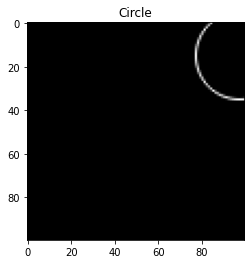

output circle


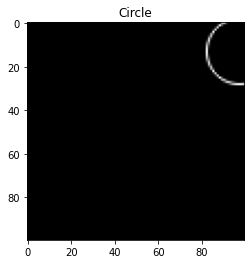

iou: 0.5625


In [29]:
# Load a batch of samples
inputs, labels = next(dataloader.__iter__())

# Convert to numpy array
outputs = trained_cnn(inputs.to(device=device)
                      ).cpu().detach().numpy().astype(int)
labels = labels.cpu().detach().numpy().astype(int)

# Show sample result/ground truth
print("ground truth circle:")
show_circle(draw_circle(np.zeros((100, 100)),
            labels[0, 0], labels[0, 1], labels[0, 2]))

print("output circle")
show_circle(draw_circle(np.zeros((100, 100)),
            outputs[0, 0], outputs[0, 1], outputs[0, 2]))

# Print iou value
print(
    f"iou: {iou(CircleParams(labels[0,0], labels[0,1], labels[0,2]), CircleParams(outputs[0,0], outputs[0,1], outputs[0,2]))}")


## Visualize first layer filters

In [34]:
import torchvision


In [41]:
# Grab the cnn's first layer filters
filters = trained_cnn.conv1.weight.cpu().detach().clone()
print(filters.size())
# normalize and prepare filters for viewing
filters = (filters - filters.min()) / filters.max()
filter_img = torchvision.utils.make_grid(filters, nrow=4)


torch.Size([8, 1, 7, 7])


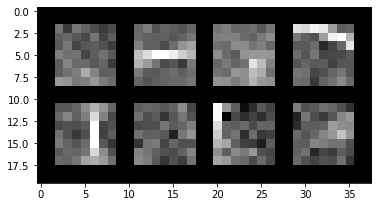

In [42]:
# Show a grid of filters
plt.imshow(filter_img.permute(1, 2, 0))


These filters look like edge detectors! The top left filter even seems circular!